<a href="https://colab.research.google.com/github/zdulbz/Multiple-Selves/blob/main/Bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
#IMPORTS 
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.colors as mcl

 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
plt.rcParams.update({'font.size': 12})


Using device: cpu


In [2]:
# BANDITS


class bandit:
  def __init__(self,mean,variance):
    self.mean = mean
    self.variance = variance
  
  def give_reward(self):
    return np.random.normal(self.mean,self.variance)

class agent:
  def __init__(self,n_actions,epsilon,lr,fav_bandit = None, starting_q = 1):
    self.n_actions = n_actions
    self.epsilon = epsilon
    self.q_values = starting_q*np.ones(n_actions)
    self.lr = lr
    self.rewards = []
    self.historical_q_values = []
    self.historical_actions = []
    self.fav_bandit = fav_bandit

  def select_action(self):
    if np.random.uniform() > self.epsilon: #and not np.all(self.q_values == self.q_values[0]):  # want to choose randomly on the first step when all vals are the same
      action = np.random.choice(np.flatnonzero(self.q_values == self.q_values.max()))
      # action = np.argmax(self.q_values)
      self.historical_actions.append(copy.copy(action))
      return action
    else:
      action = np.random.randint(self.n_actions)
      self.historical_actions.append(copy.copy(action))
      return action

  def pull(self,action,bandits):
    reward = bandits[action].give_reward()
    if self.fav_bandit is not None:
      reward *= int(action == self.fav_bandit)
    self.rewards.append(reward)
    return reward

  def update_q_values(self,action,reward):
    self.q_values[action] += self.lr*(reward - self.q_values[action])
    self.historical_q_values.append(copy.copy(self.q_values))





(0.0, 5.0)

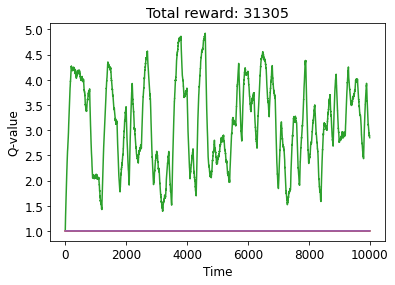

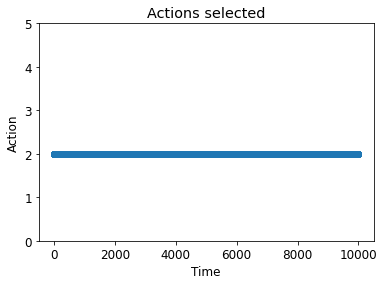

In [257]:
## monolithic bandits

mono_epsilon = 0
mono_lr = 0.01
means = [1,2,3,4,5]
vars = [1 for i in range(len(means))]
n_bandits = len(means)
starting_q = 1
bandits = [bandit(means[i],vars[i]) for i in range(n_bandits)]
mono_agent = agent(n_bandits,mono_epsilon,mono_lr,starting_q = starting_q)
trials = 10000
trial_swap = 100
epsilon_final = 0
epsilon_decay = 0

for i in range(trials):
  if i % trial_swap == 0:
    np.random.shuffle(bandits)
  action = mono_agent.select_action()
  reward = mono_agent.pull(action,bandits)
  mono_agent.update_q_values(action,reward)
  mono_agent.epsilon -= epsilon_decay
  if mono_agent.epsilon < epsilon_final: mono_agent.epsilon = epsilon_final

plt.plot(mono_agent.historical_q_values);
plt.title(f'Total reward: {int(sum(mono_agent.rewards))}')
plt.ylabel('Q-value')
plt.xlabel('Time')
plt.figure()
plt.scatter(range(trials),mono_agent.historical_actions);
plt.title('Actions selected')
plt.ylabel('Action')
plt.xlabel('Time')
plt.ylim([0,5])


In [151]:
run_monolithic(1000, 1, 1, 1, 1, 0.1)


3048

Text(0.5, 0, 'Time')

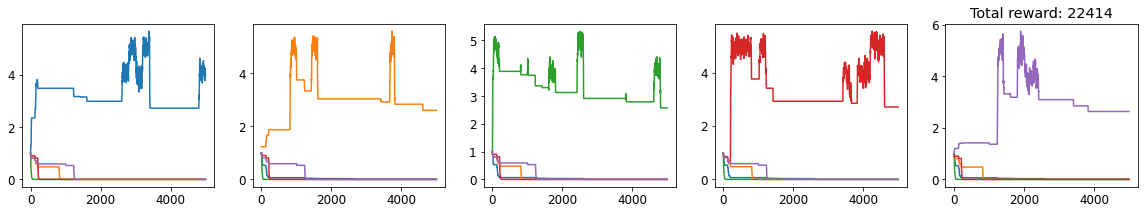

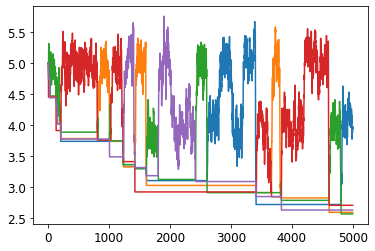

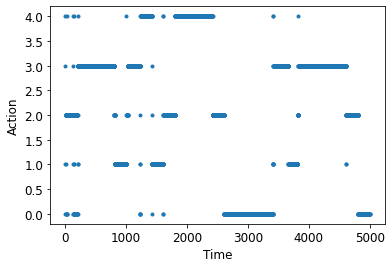

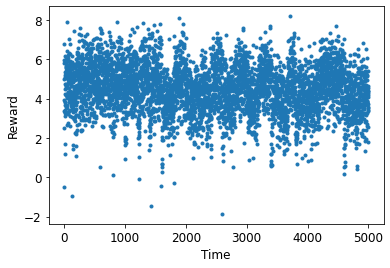

In [260]:
## multi-agent bandits
means = [1,2,3,4,5]
trial_swap = 200
n_bandits = len(means)
vars = [1 for i in range(len(means))]
bandits = [bandit(means[i],vars[i]) for i in range(n_bandits)]

n_agents = n_bandits
starting_q = 1
epsilon = 0
epsilon_final = 0
lr = 0.1
epsilon_decay = 1/1
agents = [agent(n_bandits,0,lr,fav_bandit = i,starting_q = starting_q) for i in range(n_agents)]

historical_actions = []
historical_rewards = []
historical_qvals = []

def select_multiagent_action(agents):
  q_values = sum([agents[i].q_values for i in range(n_agents)])
  historical_qvals.append(copy.copy(q_values))
  if np.random.uniform() > epsilon:# and not np.all(q_values == q_values[0]):  # want to choose randomly on the first step when all vals are the same
    action = np.random.choice(np.flatnonzero(q_values == q_values.max()))
    # action = np.argmax(q_values)
    historical_actions.append(copy.copy(action))
    return action
  else:
    action = np.random.randint(n_bandits)
    historical_actions.append(copy.copy(action))
    return action


trials = 5000

for i in range(trials):
  if i % trial_swap == 0:
    np.random.shuffle(bandits)
  action = select_multiagent_action(agents)
  reward = bandits[action].give_reward()
  historical_rewards.append(copy.copy(reward))
  reward_list = [reward*int(action == agents[i].fav_bandit) for i in range(n_agents)]
  # print(reward_list)
  for i in range(n_agents):
    agents[i].update_q_values(action,reward_list[i])
  epsilon -= epsilon_decay
  if epsilon < epsilon_final: epsilon = epsilon_final


fig, axes = plt.subplots(1,n_agents,figsize = (20,3))
for i, ax in enumerate(axes.flatten()):
    ax.plot(agents[i].historical_q_values)
plt.title(f'Total reward: {int(sum(historical_rewards))}')

plt.figure()
plt.plot(historical_qvals);
plt.figure()
# plt.plot(np.cumsum(mono_agent.rewards));
plt.scatter(range(trials),historical_actions,marker='.');
plt.ylabel('Action')
plt.xlabel('Time')

plt.figure()
plt.scatter(range(trials),historical_rewards,marker='.');
plt.ylabel('Reward')
plt.xlabel('Time')

# Comparison

In [267]:
from operator import truediv
from inspect import indentsize

def run_monolithic(trials, starting_q, epsilon_0, epsilon_decay, epsilon_final, lr):

  n_bandits = len(means)
  vars = [1 for i in range(n_bandits)]
  bandits = [bandit(means[i],vars[i]) for i in range(n_bandits)]
  mono_agent = agent(n_bandits,epsilon_0,lr,starting_q = starting_q)

  for i in range(trials):
    if SWAP:
      if i % trial_swap == 0:
        np.random.shuffle(bandits)
    action = mono_agent.select_action()
    reward = mono_agent.pull(action,bandits)
    mono_agent.update_q_values(action,reward)
    # mono_agent.epsilon -= epsilon_decay
    # if mono_agent.epsilon < epsilon_final: mono_agent.epsilon = epsilon_final

  return int(sum(mono_agent.rewards))

def run_random(trials):

  n_bandits = len(means)
  vars = [1 for i in range(n_bandits)]
  bandits = [bandit(means[i],vars[i]) for i in range(n_bandits)]
  reward = 0

  for i in range(trials):
    if SWAP:
      if i % trial_swap == 0:
        np.random.shuffle(bandits)
    action = np.random.choice(n_bandits)
    reward += bandits[action].give_reward()

  return reward

def run_modular(trials, starting_q, epsilon_0, epsilon_decay, epsilon_final, lr, CEO=False):

  n_bandits = len(means)
  vars = [1 for i in range(n_bandits)]
  bandits = [bandit(means[i],vars[i]) for i in range(n_bandits)]
  n_agents = n_bandits
  epsilon = epsilon_0
  agents = [agent(n_bandits,0,lr,fav_bandit = i,starting_q = starting_q) for i in range(n_agents)]
  CEO_agent = agent(n_bandits,epsilon,lr,starting_q = starting_q)

  historical_actions = []
  historical_rewards = []
  historical_qvals = []

  def select_multiagent_action(agents):
    q_values = sum([agents[i].q_values for i in range(n_agents)])
    historical_qvals.append(copy.copy(q_values))
    if np.random.uniform() > epsilon:# and not np.all(q_values == q_values[0]):  
      action = np.random.choice(np.flatnonzero(q_values == q_values.max())) # want to choose randomly on the first step when all vals are the same
      # action = np.argmax(q_values)
      historical_actions.append(copy.copy(action))
      return action
    else:
      action = np.random.randint(n_bandits)
      historical_actions.append(copy.copy(action))
      return action

  for i in range(trials):
    if SWAP:
      if i % trial_swap == 0:
        np.random.shuffle(bandits)

    if CEO:
      ceo_action = CEO_agent.select_action()
      action = agents[ceo_action].select_action()
      # CEO_agent.epsilon -= epsilon_decay
      # if CEO_agent.epsilon < epsilon_final: CEO_agent.epsilon = epsilon_final

    else:
      action = select_multiagent_action(agents)

    reward = bandits[action].give_reward()
    historical_rewards.append(copy.copy(reward))
    reward_list = [reward*int(action == agents[i].fav_bandit) for i in range(n_agents)]

    if CEO:
      CEO_agent.update_q_values(action,reward)
    # print(reward_list)
    for i in range(n_agents):
      agents[i].update_q_values(action,reward_list[i])

    # epsilon -= epsilon_decay
    # if epsilon < epsilon_final: epsilon = epsilon_final

  return int(sum(historical_rewards))

### MAIN COMPARISON LOOP ####
## main bandits
trials = 5000
SWAP = False
trial_swap = 200
repeats = 10
means = [1,2,3,4,5]
starting_q = [5,6,7,8,9]
epsilon_0 = [0,0.1,0.2,0.3]
epsilon_final = 0
# epsilon_decay = 0.01
# epsilon_decay = [1/1,1/100]
lr = 0.01

# mono_results = np.empty((repeats,len(starting_q),len(epsilon_decay),len(epsilon_final)))
# mod_results = np.empty((repeats,len(starting_q),len(epsilon_decay),len(epsilon_final)))
# CEO_results = np.empty((repeats,len(starting_q),len(epsilon_decay),len(epsilon_final)))

mono_results = np.empty((repeats,len(starting_q),len(epsilon_0)))
mod_results = np.empty((repeats,len(starting_q),len(epsilon_0)))
CEO_results = np.empty((repeats,len(starting_q),len(epsilon_0)))


for i in range(repeats):
  for j in range(len(starting_q)):
    for k in range(len(epsilon_0)):
        mono_results[i,j,k] = run_monolithic(trials, starting_q[j], epsilon_0[k], epsilon_decay, epsilon_final, lr)
        mod_results[i,j,k] = run_modular(trials, starting_q[j], epsilon_0[k], epsilon_decay, epsilon_final, lr)
        CEO_results[i,j,k] = run_modular(trials, starting_q[j], epsilon_0[k], epsilon_decay, epsilon_final, lr, CEO=True)

# get random agent stats
it = 100
r_rand = np.empty(it)
for i in range(it):
  r_rand[i] = run_random(trials)


# Plot Results

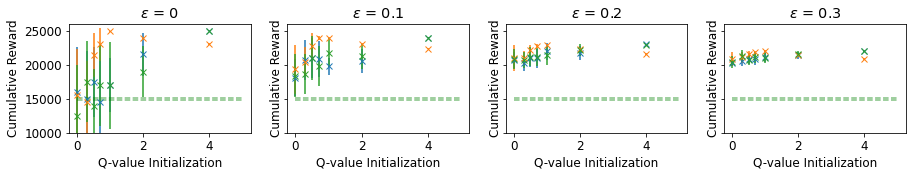

In [272]:
# results
x = np.linspace(0,5,5)

# for l in range(len(epsilon_final)):

fig, axes = plt.subplots(1,len(epsilon_0),figsize = (15,2),sharex=True, sharey=True)

for k, ax in enumerate(axes.flatten()):

  y = np.mean(mono_results[:,:,k],0)
  e = np.std(mono_results[:,:,k],0)
  ax.errorbar(starting_q, y, e, linestyle='None', marker='x')

  y = np.mean(mod_results[:,:,k],0)
  e = np.std(mod_results[:,:,k],0)
  ax.errorbar(starting_q, y, e, linestyle='None', marker='x')

  y = np.mean(CEO_results[:,:,k],0)
  e = np.std(CEO_results[:,:,k],0)
  ax.errorbar(starting_q, y, e, linestyle='None', marker='x')

  ax.plot(x,(r_rand.mean()+r_rand.std())*np.ones(len(x)),'g--',alpha=0.5)
  ax.plot(x,(r_rand.mean()-r_rand.std())*np.ones(len(x)),'g--',alpha=0.5)


  ax.set_title(f'$\epsilon$ = {epsilon_0[k]}')
  ax.set_xlabel('Q-value Initialization')
  ax.set_ylabel('Cumulative Reward')
  # ax.set_ylim([min(np.min(mod_results),np.min(mono_results),np.min(CEO_results)),max(np.max(mod_results),np.max(mono_results),np.max(CEO_results))])
  ax.set_ylim(10000,26000)
# plt.legend(['Monolithic','Modular','Hierarhical'])



In [25]:
min(np.min(mod_results),np.min(mod_results),np.min(CEO_results))

1764.0

In [106]:
r_rand.std()

57.12710167448709